In [1]:
# %load /home/mithrillion/default_imports.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline
import re
from collections import Counter
from functools import partial

import folium
import boto3
from time import sleep

In [2]:
client = boto3.client('athena')

In [3]:
def query_to_df(res):
    colnames = [x['Name'] for x in res['ResultSet']['ResultSetMetadata']['ColumnInfo']]
    typemap = {'bigint': np.int32, 'varchar': np.str, 'double': np.double, 'boolean': np.bool}
    coltypes = [typemap[x['Type']] for x in res['ResultSet']['ResultSetMetadata']['ColumnInfo']]
    rows = [[item['VarCharValue'] for item in row['Data']] for row in res['ResultSet']['Rows'][1:]]
    df = pd.DataFrame(rows, columns=colnames)
    for n, t in zip(colnames, coltypes):
        if t == np.bool:
            df[n] = (df[n] == 'true')
        df[n] = df[n].astype(t)
    return df

In [4]:
def get_result(job):
    while (True):
        try:
            paginator = client.get_paginator('get_query_results')
            p = paginator.paginate(QueryExecutionId=job['QueryExecutionId'])
            return pd.concat([query_to_df(part) for part in p], axis=0)
        except Exception as e:
            if str(e)[-7:] == 'RUNNING':
                sleep(10)
            else:
                print(e)
                break

## Card Type Breakdown

In [5]:
query = """
SELECT
  CardType,
  Card_SubType_Desc,
  Concession_Type,
  COUNT(DISTINCT CardID) Cnt
FROM
  samp0,
  card_types
WHERE
  CardType = Card_SubType_ID
GROUP BY
  CardType,
  Card_SubType_Desc,
  Concession_Type
ORDER BY
  Cnt DESC
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [6]:
job

{'QueryExecutionId': '74bd06c2-5087-493c-bb2b-24207faae81b',
 'ResponseMetadata': {'RequestId': '77a68386-ed80-4904-8cd0-af461439bb88',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 02 Sep 2018 13:24:34 GMT',
   'x-amzn-requestid': '77a68386-ed80-4904-8cd0-af461439bb88',
   'content-length': '59',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [7]:
card_type_breakdown = get_result(job)

In [8]:
card_type_breakdown.head()

,CardType,Card_SubType_Desc,Concession_Type,Cnt
0,1,Full Fare,Full Fare,1026543
1,2,General Concession,Other Concession,190308
2,9,Victorian Seniors Concession,Seniors,111246
3,4,Child Concession 5 yrs to <= 18yrs,Child,69666
4,0,Default Full Fare,Full Fare,44824


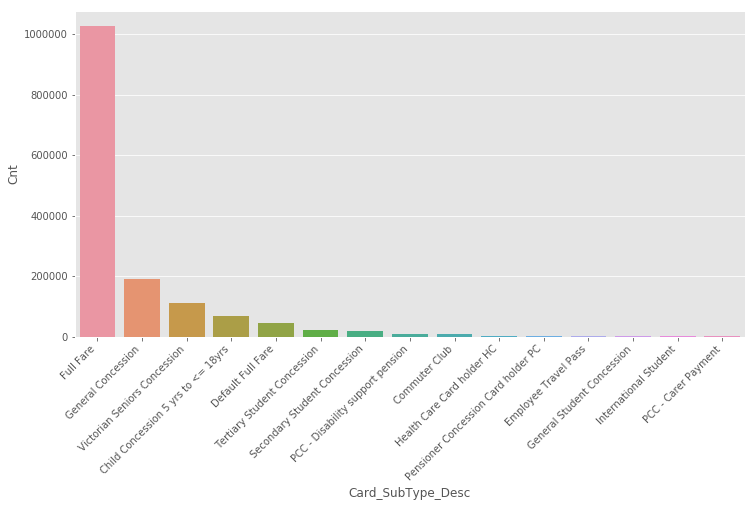

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.barplot(data=card_type_breakdown.iloc[:15, :], x='Card_SubType_Desc', y='Cnt', ax=ax)
g.set_xticklabels(g.get_xmajorticklabels(), rotation=45, ha='right')
plt.show()

## Transaction Count Over Time

In [10]:
query = """
SELECT
  YEAR(DateTime) AS Year,
  MONTH(DateTime) AS Month,
  Count(*) Cnt
FROM
  samp0
GROUP BY
  YEAR(DateTime), MONTH(DateTime)
ORDER BY
  Year ASC, Month ASC
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [11]:
trx_over_time = get_result(job)

In [12]:
trx_over_time.head()

,Year,Month,Cnt
0,2015,7,5180114
1,2015,8,5355430
2,2015,9,5184339
3,2015,10,5329529
4,2015,11,4943649


/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


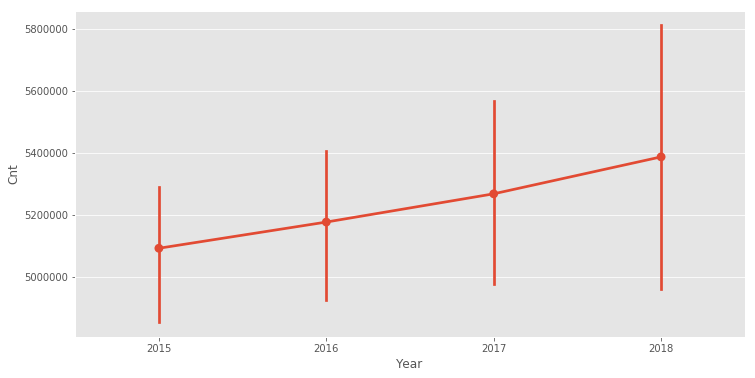

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=trx_over_time.iloc[:-1], x='Year', y='Cnt', ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


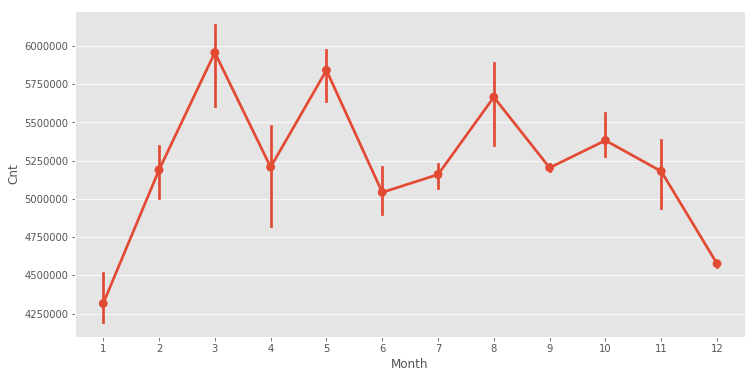

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=trx_over_time.iloc[:-1], x='Month', y='Cnt', ax=ax)
plt.show()

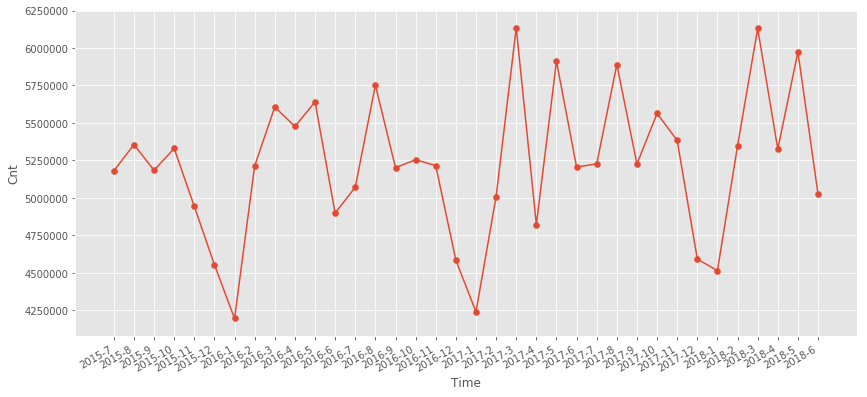

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
ym = trx_over_time.iloc[:-1][['Year', 'Month']].apply(lambda x: '{0}-{1}'.format(x[0], x[1]), axis=1)
plt.plot(trx_over_time.iloc[:-1].index, trx_over_time.iloc[:-1]['Cnt'])
plt.scatter(trx_over_time.iloc[:-1].index, trx_over_time.iloc[:-1]['Cnt'])
ax.set_xlabel('Time')
ax.set_ylabel('Cnt')
plt.xticks(trx_over_time.iloc[:-1].index, ym, rotation=30, ha='right')
plt.show()

## Transcation Count over Week

In [16]:
query = """
SELECT
  day_of_week(DateTime) DoW,
  hour(DateTime) Hour,
  Count(*) Cnt
FROM
  samp0
GROUP BY
  day_of_week(DateTime), hour(DateTime)
ORDER BY
  DoW ASC, Hour ASC
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [17]:
trx_over_week = get_result(job)

In [18]:
trx_over_week.head()

,DoW,Hour,Cnt
0,1,0,41398
1,1,1,1996
2,1,2,310
3,1,3,317
4,1,4,15248


/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


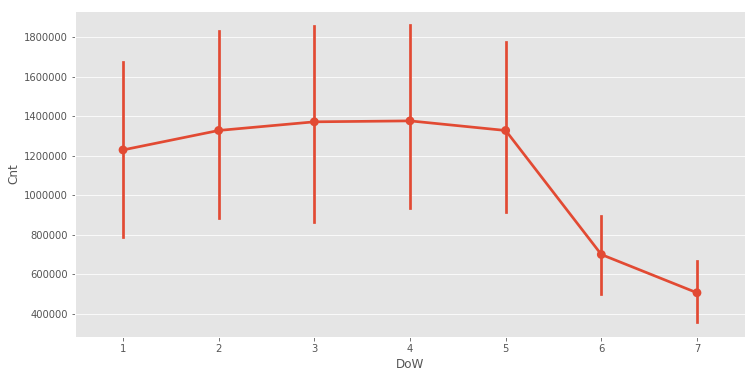

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=trx_over_week, x='DoW', y='Cnt', ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


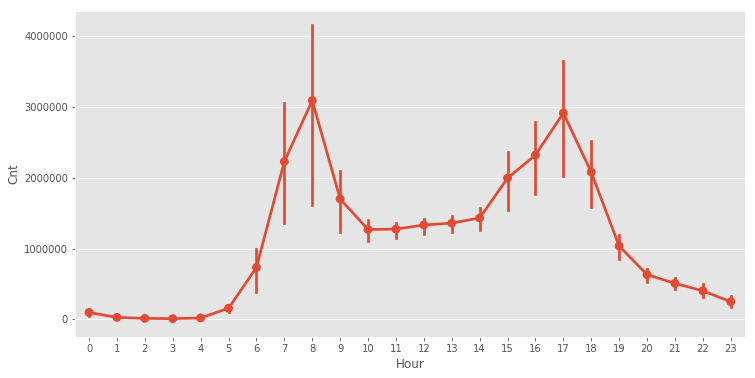

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=trx_over_week, x='Hour', y='Cnt', ax=ax)
plt.show()

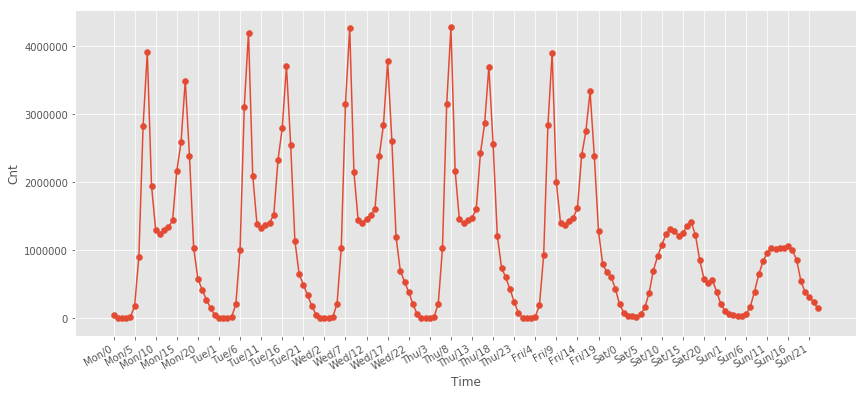

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dh = trx_over_week[['DoW', 'Hour']].apply(lambda x: '{0}/{1}'.format(days[x[0] - 1], x[1]), axis=1)
plt.plot(trx_over_week.index, trx_over_week['Cnt'])
plt.scatter(trx_over_week.index, trx_over_week['Cnt'])
ax.set_xlabel('Time')
ax.set_ylabel('Cnt')
ind = trx_over_week.index % 5 == 0
plt.xticks(trx_over_week.index[ind], dh[ind], rotation=30, ha='right')
plt.show()

## On vs Off, per Hour and per DoW

In [22]:
query = """
SELECT
  day_of_week(DateTime) DoW,
  hour(DateTime) Hour,
  IsOn,
  Count(*) Cnt
FROM
  samp0
GROUP BY
  day_of_week(DateTime), hour(DateTime), IsOn
ORDER BY
  DoW ASC, Hour ASC, IsOn
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [23]:
on_off_over_week = get_result(job)

In [24]:
on_off_over_week.head()

,DoW,Hour,IsOn,Cnt
0,1,0,False,28393
1,1,0,True,13005
2,1,1,False,1499
3,1,1,True,497
4,1,2,False,95


/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


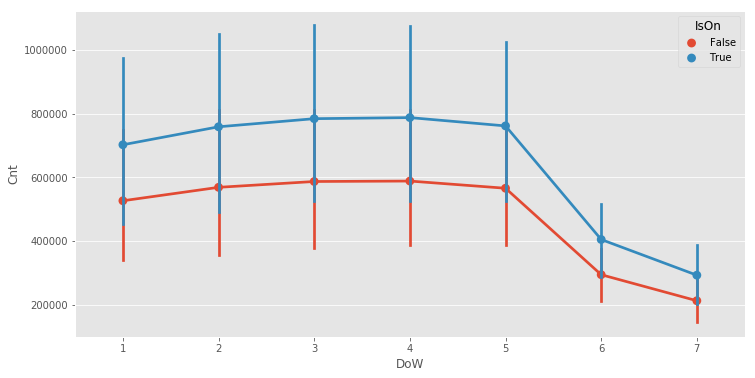

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_week, x='DoW', y='Cnt', hue='IsOn', ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


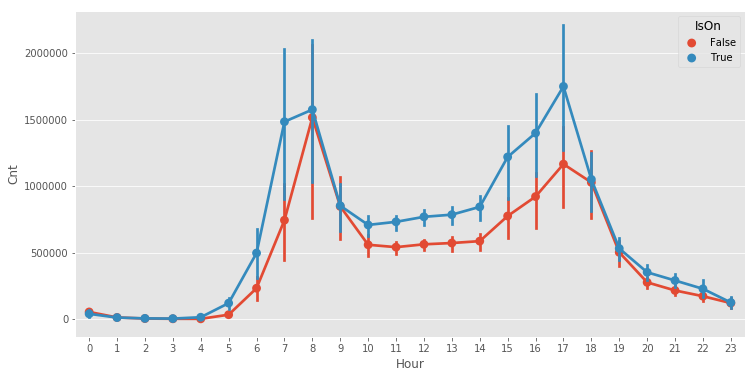

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_week, x='Hour', y='Cnt', hue='IsOn', ax=ax)
plt.show()

In [27]:
on_off_over_week_piv = on_off_over_week.pivot_table(index=['DoW', 'Hour'], columns=['IsOn'], values=['Cnt'])
on_off_over_week_piv[('Cnt', 'Ratio')] = on_off_over_week_piv[(
    'Cnt', False)] / on_off_over_week_piv[('Cnt', True)]
on_off_over_week_piv.head()

Cnt                 
IsOn      False   True     Ratio
DoW Hour                        
1   0     28393  13005  2.183237
    1      1499    497  3.016097
    2        95    215  0.441860
    3        68    249  0.273092
    4       710  14538  0.048838

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


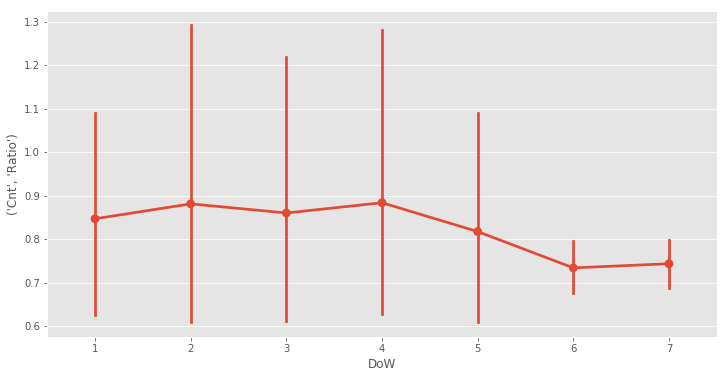

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_week_piv.reset_index(), x='DoW', y=('Cnt', 'Ratio'), ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


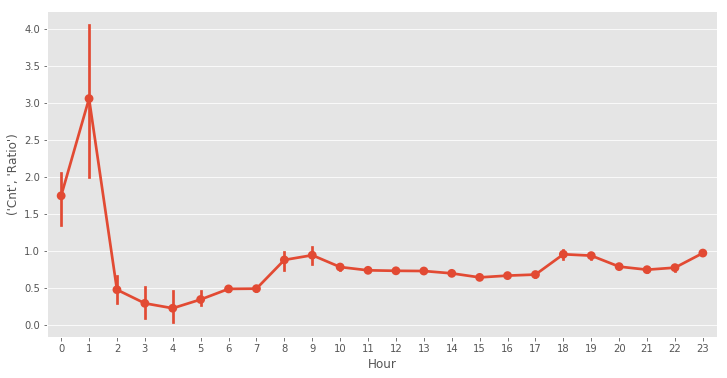

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_week_piv.reset_index(), x='Hour', y=('Cnt', 'Ratio'), ax=ax)
plt.show()

## On vs Off, over Time

In [30]:
query = """
SELECT
  year(DateTime) Year,
  month(DateTime) Month,
  IsOn,
  Count(*) Cnt
FROM
  samp0
GROUP BY
  year(DateTime), month(DateTime), IsOn
ORDER BY
  Year ASC, Month ASC, IsOn
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [33]:
on_off_over_time = get_result(job)

In [34]:
on_off_over_time = on_off_over_time.iloc[:-2]

In [35]:
on_off_over_time.head()

,Year,Month,IsOn,Cnt
0,2015,7,False,2200297
1,2015,7,True,2979817
2,2015,8,False,2273744
3,2015,8,True,3081686
4,2015,9,False,2201126


In [36]:
on_off_over_time_piv = on_off_over_time.pivot_table(index=['Year', 'Month'], columns=['IsOn'], values=['Cnt'])
on_off_over_time_piv[('Cnt', 'Ratio')] = on_off_over_time_piv[(
    'Cnt', False)] / on_off_over_time_piv[('Cnt', True)]
on_off_over_time_piv.head()

Cnt                   
IsOn          False     True     Ratio
Year Month                            
2015 7      2200297  2979817  0.738400
     8      2273744  3081686  0.737825
     9      2201126  2983213  0.737837
     10     2255192  3074337  0.733554
     11     2094463  2849186  0.735109

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


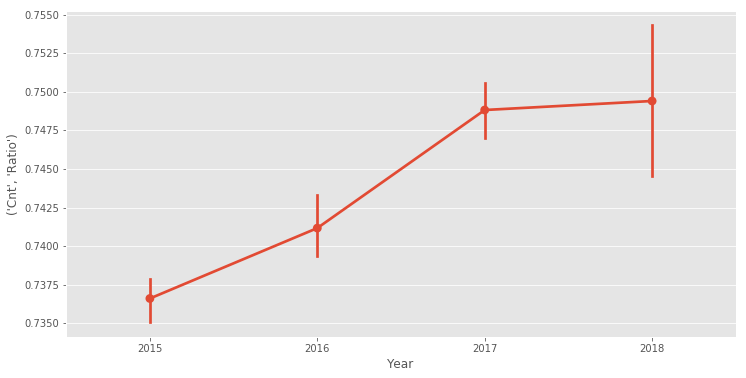

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_time_piv.reset_index(), x='Year', y=('Cnt', 'Ratio'), ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


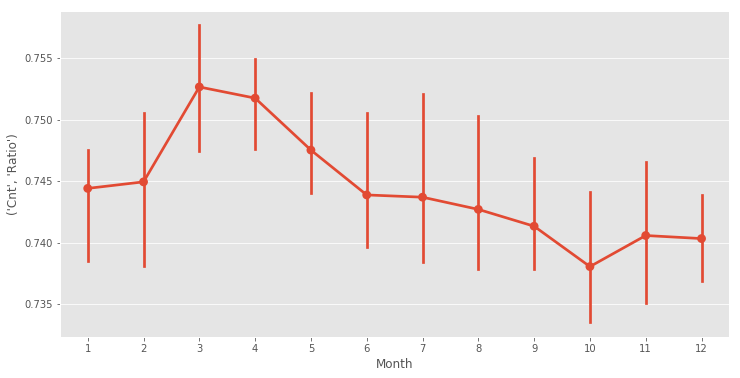

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(data=on_off_over_time_piv.reset_index(), x='Month', y=('Cnt', 'Ratio'), ax=ax)
plt.show()

## On vs Off per Stop by Mode

In [39]:
query = """
SELECT
  Mode,
  StopID,
  IsOn,
  Count(*) Cnt
FROM
  samp0
GROUP BY
  Mode, StopID, IsOn
ORDER BY
  Mode, StopID, IsOn
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [42]:
on_off_per_stop_by_mode = get_result(job)

In [43]:
on_off_per_stop_by_mode.head()

,Mode,StopID,IsOn,Cnt
0,1,-1,False,1403
1,1,-1,True,844
2,1,4,False,355
3,1,4,True,137
4,1,5,False,54


In [45]:
on_off_per_stop_by_mode_piv = on_off_per_stop_by_mode.pivot_table(
    index=['Mode', 'StopID'], columns=['IsOn'], values=['Cnt'])
on_off_per_stop_by_mode_piv[('Cnt', 'Ratio')] = on_off_per_stop_by_mode_piv[(
    'Cnt', False)] / on_off_per_stop_by_mode_piv[('Cnt', True)]
on_off_per_stop_by_mode_piv.head()

Cnt                  
IsOn          False    True     Ratio
Mode StopID                          
1    -1      1403.0   844.0  1.662322
      4       355.0   137.0  2.591241
      5        54.0   911.0  0.059276
      6        71.0  1312.0  0.054116
      7        71.0   658.0  0.107903

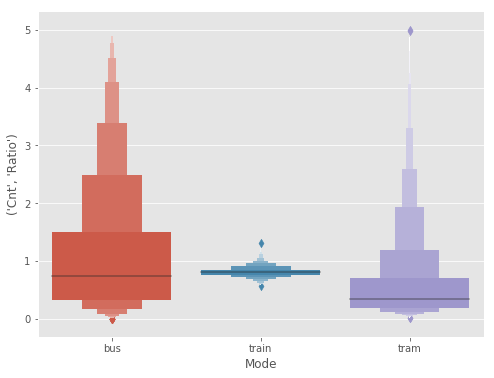

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(
    data=on_off_per_stop_by_mode_piv[on_off_per_stop_by_mode_piv[(
        "Cnt", "Ratio")] <= 5].reset_index(),
    x="Mode",
    y=("Cnt", "Ratio"),
    ax=ax)
ax.set_xticklabels(['bus', 'train', 'tram'])
plt.show()

## Breakdown by Mode

In [50]:
query = """
SELECT
  year(DateTime) Year,
  month(DateTime) Month,
  day_of_week(DateTime) DoW,
  hour(DateTime) Hour,
  Mode,
  Count(*) Cnt
FROM
  samp0
WHERE
    year(DateTime) != 2018 
    OR month(DateTime) != 7
GROUP BY
  year(DateTime), month(DateTime), day_of_week(DateTime), hour(DateTime), Mode
ORDER BY
  Year ASC, Month ASC, DoW ASC, Hour ASC, Mode
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [51]:
mode_breakdown = get_result(job)

In [52]:
mode_breakdown['Mode'] = mode_breakdown['Mode'].replace({1: 'bus', 2: 'train', 3: 'tram'})

In [54]:
mode_breakdown.head()

,Year,Month,DoW,Hour,Mode,Cnt
0,2015,7,1,0,bus,7
1,2015,7,1,0,train,583
2,2015,7,1,0,tram,139
3,2015,7,1,1,train,17
4,2015,7,1,4,bus,20


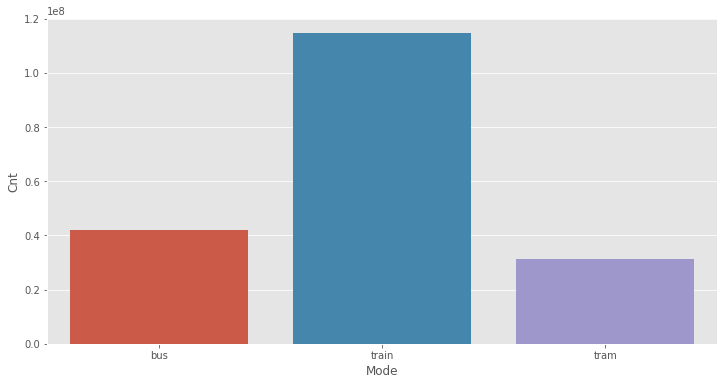

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.barplot(
    data=mode_breakdown.groupby('Mode')['Cnt'].sum().reset_index(),
    x='Mode',
    y='Cnt',
    ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


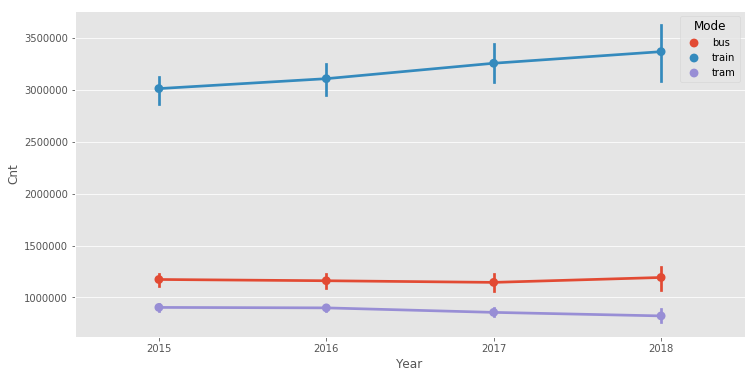

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(
    data=mode_breakdown.groupby(['Year', 'Month', 'Mode'])['Cnt'].sum().reset_index(),
    x='Year',
    y='Cnt',
    hue='Mode',
    ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


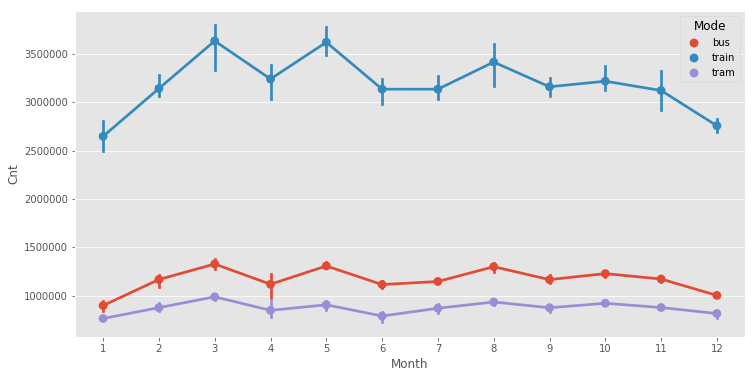

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(
    data=mode_breakdown.groupby(['Year', 'Month', 'Mode'])['Cnt'].sum().reset_index(),
    x='Month',
    y='Cnt',
    hue='Mode',
    ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


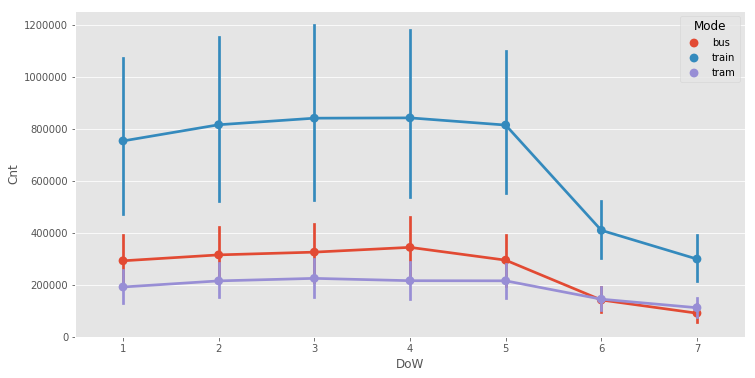

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(
    data=mode_breakdown.groupby(['DoW', 'Hour', 'Mode'])['Cnt'].sum().reset_index(),
    x='DoW',
    y='Cnt',
    hue='Mode',
    ax=ax)
plt.show()

/home/mithrillion/anaconda3/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


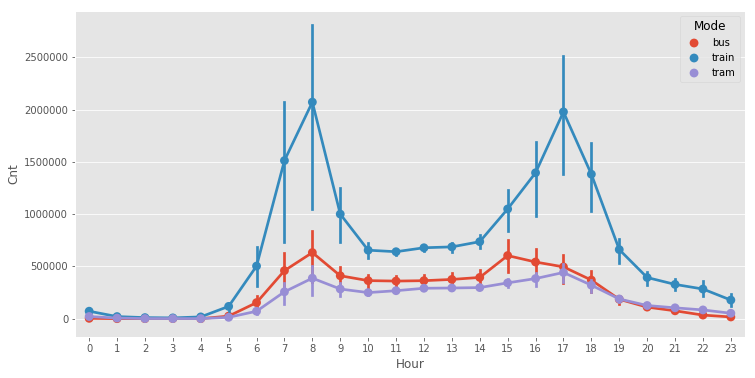

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
g = sns.pointplot(
    data=mode_breakdown.groupby(['DoW', 'Hour', 'Mode'])['Cnt'].sum().reset_index(),
    x='Hour',
    y='Cnt',
    hue='Mode',
    ax=ax)
plt.show()

## Top Trip (over Time)

In [60]:
query = """
WITH
  trips_cnt AS (
  SELECT
    StartStopID,
    DestStopID,
    COUNT(*) Cnt
  FROM
    trips
  GROUP BY
    StartStopID,
    DestStopID)
SELECT
  StartStopID,
  S1.StopNameLong StartStopName,
  DestStopID,
  S2.StopNameLong DestStopName,
  Cnt
FROM
  trips_cnt,
  stops S1,
  stops S2
WHERE
  trips_cnt.StartStopID = S1.StopLocationID
  AND trips_cnt.DestStopID = S2.StopLocationID
ORDER BY
  Cnt DESC
LIMIT
  1000
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [61]:
top_trips = get_result(job)

In [68]:
top_trips.head(20)

,StartStopID,StartStopName,DestStopID,DestStopName,Cnt
0,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),210184
1,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),182914
2,64404,Flinders Street Railway Station (Melbourne City),19959,South Yarra Railway Station (South Yarra),180214
3,64404,Flinders Street Railway Station (Melbourne City),64408,Southern Cross Railway Station (Melbourne City),174008
4,64404,Flinders Street Railway Station (Melbourne City),20025,Footscray Railway Station (Footscray),173879
5,20042,Box Hill Railway Station (Box Hill),64404,Flinders Street Railway Station (Melbourne City),166580
6,64404,Flinders Street Railway Station (Melbourne City),19943,Caulfield Railway Station (Caulfield East),165059
7,19943,Caulfield Railway Station (Caulfield East),64404,Flinders Street Railway Station (Melbourne City),162549
8,64402,Melbourne Central Railway Station (Melbourne C...,20025,Footscray Railway Station (Footscray),157397
9,19873,Glen Waverley Railway Station (Glen Waverley),64404,Flinders Street Railway Station (Melbourne City),154015


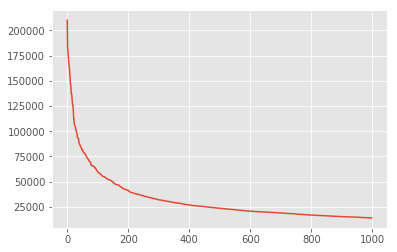

In [63]:
plt.plot(top_trips['Cnt'])
plt.show()

In [65]:
query = """
WITH
  trips_cnt AS (
  SELECT
    hour(StartTime) AS Hour,
    StartStopID,
    DestStopID,
    COUNT(*) Cnt
  FROM
    trips
  GROUP BY
    hour(StartTime),
    StartStopID,
    DestStopID),
  top_trips AS (
  SELECT
    Hour,
    StartStopID,
    DestStopID,
    Cnt,
    ROW_NUMBER() OVER (PARTITION BY Hour ORDER BY Cnt DESC) Ord
  FROM
    trips_cnt )
SELECT
  Hour,
  Ord,
  StartStopID,
  S1.StopNameLong StartStopName,
  DestStopID,
  S2.StopNameLong DestStopName,
  Cnt
FROM
  top_trips,
  stops S1,
  stops S2
WHERE
  top_trips.StartStopID = S1.StopLocationID
  AND top_trips.DestStopID = S2.StopLocationID
  AND Ord <= 3
ORDER BY
  Hour, Ord
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [66]:
top_trips_by_hour = get_result(job)

In [71]:
top_trips_by_hour.query('Ord == 1')

,Hour,Ord,StartStopID,StartStopName,DestStopID,DestStopName,Cnt
0,0,1,64404,Flinders Street Railway Station (Melbourne City),20025,Footscray Railway Station (Footscray),2636
3,1,1,64404,Flinders Street Railway Station (Melbourne City),19943,Caulfield Railway Station (Caulfield East),1467
6,2,1,64404,Flinders Street Railway Station (Melbourne City),19943,Caulfield Railway Station (Caulfield East),1105
9,3,1,64404,Flinders Street Railway Station (Melbourne City),19943,Caulfield Railway Station (Caulfield East),841
12,4,1,19921,Werribee Railway Station (Werribee),64404,Flinders Street Railway Station (Melbourne City),1036
15,5,1,45795,South Morang Railway Station (South Morang),64404,Flinders Street Railway Station (Melbourne City),5124
18,6,1,45795,South Morang Railway Station (South Morang),64404,Flinders Street Railway Station (Melbourne City),17943
21,7,1,46468,Williams Landing Railway Station (Williams Lan...,64408,Southern Cross Railway Station (Melbourne City),35638
24,8,1,20025,Footscray Railway Station (Footscray),64408,Southern Cross Railway Station (Melbourne City),31632
27,9,1,20025,Footscray Railway Station (Footscray),64402,Melbourne Central Railway Station (Melbourne C...,15856


In [74]:
query = """
WITH
  trips_cnt AS (
  SELECT
    day_of_week(StartTime) AS DoW,
    StartStopID,
    DestStopID,
    COUNT(*) Cnt
  FROM
    trips
  GROUP BY
    day_of_week(StartTime),
    StartStopID,
    DestStopID),
  top_trips AS (
  SELECT
    DoW,
    StartStopID,
    DestStopID,
    Cnt,
    ROW_NUMBER() OVER (PARTITION BY DoW ORDER BY Cnt DESC) Ord
  FROM
    trips_cnt )
SELECT
  DoW,
  Ord,
  StartStopID,
  S1.StopNameLong StartStopName,
  DestStopID,
  S2.StopNameLong DestStopName,
  Cnt
FROM
  top_trips,
  stops S1,
  stops S2
WHERE
  top_trips.StartStopID = S1.StopLocationID
  AND top_trips.DestStopID = S2.StopLocationID
  AND Ord <= 3
ORDER BY
  DoW, Ord
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [75]:
top_trips_by_dow = get_result(job)

In [77]:
top_trips_by_dow

,DoW,Ord,StartStopID,StartStopName,DestStopID,DestStopName,Cnt
0,1,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),31821
1,1,2,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),27469
2,1,3,64404,Flinders Street Railway Station (Melbourne City),64408,Southern Cross Railway Station (Melbourne City),25568
3,2,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),35109
4,2,2,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),29103
5,2,3,64404,Flinders Street Railway Station (Melbourne City),19959,South Yarra Railway Station (South Yarra),27377
6,3,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),37815
7,3,2,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),31121
8,3,3,64404,Flinders Street Railway Station (Melbourne City),19959,South Yarra Railway Station (South Yarra),28482
9,4,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),38244


In [79]:
query = """
WITH
  trips_cnt AS (
  SELECT
    month(StartTime) AS Month,
    StartStopID,
    DestStopID,
    COUNT(*) Cnt
  FROM
    trips
  GROUP BY
    month(StartTime),
    StartStopID,
    DestStopID),
  top_trips AS (
  SELECT
    Month,
    StartStopID,
    DestStopID,
    Cnt,
    ROW_NUMBER() OVER (PARTITION BY Month ORDER BY Cnt DESC) Ord
  FROM
    trips_cnt )
SELECT
  Month,
  Ord,
  StartStopID,
  S1.StopNameLong StartStopName,
  DestStopID,
  S2.StopNameLong DestStopName,
  Cnt
FROM
  top_trips,
  stops S1,
  stops S2
WHERE
  top_trips.StartStopID = S1.StopLocationID
  AND top_trips.DestStopID = S2.StopLocationID
  AND Ord <= 3
ORDER BY
  Month, Ord
"""
job = client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={'Database': 'melb-dthon'},
    ResultConfiguration={
        'OutputLocation':
        's3://aws-athena-query-results-796452490322-us-east-2/',
        'EncryptionConfiguration': {
            'EncryptionOption': 'SSE_S3',
        }
    })

In [80]:
top_trips_by_month = get_result(job)

In [81]:
top_trips_by_month

,Month,Ord,StartStopID,StartStopName,DestStopID,DestStopName,Cnt
0,1,1,20042,Box Hill Railway Station (Box Hill),64404,Flinders Street Railway Station (Melbourne City),16766
1,1,2,64404,Flinders Street Railway Station (Melbourne City),20042,Box Hill Railway Station (Box Hill),15432
2,1,3,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),15099
3,2,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),17334
4,2,2,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),15325
5,2,3,64404,Flinders Street Railway Station (Melbourne City),19959,South Yarra Railway Station (South Yarra),14852
6,3,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),19037
7,3,2,20025,Footscray Railway Station (Footscray),64404,Flinders Street Railway Station (Melbourne City),17717
8,3,3,64404,Flinders Street Railway Station (Melbourne City),64408,Southern Cross Railway Station (Melbourne City),16815
9,4,1,19959,South Yarra Railway Station (South Yarra),64404,Flinders Street Railway Station (Melbourne City),17135
